# Predicting tags for the given code
### Using simple models (SVM, LogReg, Naive Bayes, LGBM)

In [29]:
# !pip install dagshub

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

import pickle
import dagshub

In [31]:
def load_code_blocks(DATASET_PATH, CODE_COLUMN):
    df = pd.read_csv(DATASET_PATH, encoding='utf-8', comment='#', sep='\t')#, quoting=csv.QUOTE_NONE, error_bad_lines=False)#, sep=','
    print("Data of {} shape has been loaded".format(df.shape))
    print(df.columns)
    code_blocks = df[CODE_COLUMN]
    # test_size = 0.1
    # test_rows = round(df.shape[0]*test_size)
    # train_rows = df.shape[0] - test_rows
    # train_code_blocks = df[CODE_COLUMN][0:test_rows]
    # test_code_blocks = df[CODE_COLUMN][train_rows:]
    return df, code_blocks

In [32]:
def tfidf_fit_transform(code_blocks, params, TFIDF_DIR):
    vectorizer = TfidfVectorizer(params)
    tfidf = vectorizer.fit(code_blocks)
    pickle.dump(tfidf, open("tfidf.pickle", "wb"))
    code_blocks_tfidf = tfidf.transform(code_blocks)
    print("tfidf trained, saved and transformed")
    return code_blocks_tfidf

In [33]:
def tfidf_transform(code_blocks, params, TFIDF_DIR):
    tfidf = pickle.load(open(TFIDF_DIR, 'rb'))
    code_blocks_tfidf = tfidf.transform(code_blocks)
    print("tfidf loaded and transformed")
    return code_blocks_tfidf

In [34]:
def SVM_evaluate(df, code_blocks, tfidf_params, TFIDF_DIR, SVM_params):
    code_blocks_tfidf = tfidf_fit_transform(code_blocks, tfidf_params, TFIDF_DIR)
    X_train, X_test, y_train, y_test = train_test_split(code_blocks_tfidf, df[TAG_TO_PREDICT], test_size=0.3)
    # grid = {"C": [100]}
    # cv = KFold(n_splits=2, shuffle=True, random_state=241)
    # model = SVC(kernel="linear", random_state=241)
    # gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
    # gs.fit(X_train[:25000], y_train.ravel()[:25000])
    # C = gs.best_params_.get('C')
    model = SVC(**SVM_params)
    # model.set_params(SVM_params)
    print(model.get_params())
    model.fit(X_train, y_train.ravel())
    # a faster option:
    # 1: usage of BagginClassifier decreased the fitting time from 38 mins to 8
    # n_estimators = 10
    clf = model
    # clf = BaggingClassifier(model, max_samples=1.0 / n_estimators, n_estimators=n_estimators)
    # clf.fit(X_train, y_train.ravel())
    pickle.dump(clf, open(MODEL_DIR, 'wb'))
    # y_pred = model.predict(X_test)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1}
    plot_confusion_matrix(model, X_test, y_test)
    return metrics

In [35]:
def get_predictions(X, y, TAG_TO_PREDICT, MODEL_DIR):
    clf = pickle.load(open(MODEL_DIR, 'rb'))
    print("the model has been loaded")
    # result = loaded_model.score(X, y)
    y_pred = clf.predict(X)
    print("predictions were calculated")
    accuracy = clf.score(X, y)
    f1 = f1_score(y_pred, y, average='weighted')
    print(f'Mean Accuracy {round(accuracy*100, 2)}%')
    print(f'F1-score {round(f1*100, 2)}%')
    errors = y - y_pred
    plt.hist(errors)
    plot_precision_recall_curve(clf, X, y)
    plot_confusion_matrix(clf, X, y, values_format='d')
    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    conf_interval = mean_confidence_interval(errors, 0.95)
    print(conf_interval)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1
               , 'conf_interval': conf_interval}
    return metrics
    print(result)

Data of (224, 2) shape has been loaded
Index(['code', 'tag'], dtype='object')
loaded
tfidf loaded and transformed
the model has been loaded
predictions were calculated
Mean Accuracy 50.45%
F1-score 58.09%
(0.3169642857142857, 0.23401823496855037, 0.39991033646002105)
finished


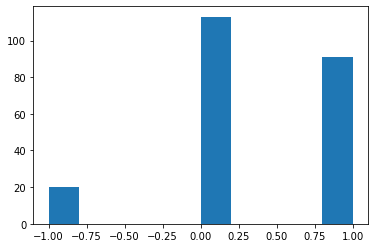

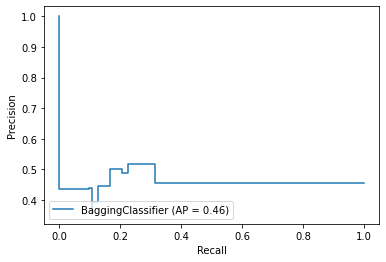

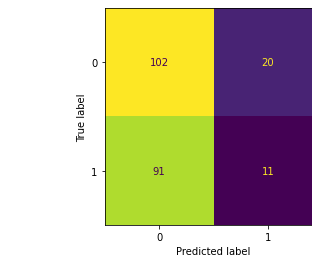

In [42]:
if __name__ == '__main__':
    DATASET_PATH = './data/chunks_25_validate.csv'
    MODEL_DIR = './models/svm_regex_graph_v2.sav'
    TFIDF_DIR = './models/tfidf_svm_graph_v2.pickle'
    CODE_COLUMN = 'code' #'code_block'
    TAG_TO_PREDICT = 'tag' #'preprocessing'
    df, code_blocks = load_code_blocks(DATASET_PATH, CODE_COLUMN)
    nrows = df.shape[0]
    print("loaded")
    tfidf_params = {'min_df': 5
            , 'max_df': 0.3
            , 'smooth_idf': True}
    SVM_params = {'C': 100
            , 'kernel': "linear"
            , 'verbose': 1
            , 'random_state': 241}
    meta = {'data': DATASET_PATH
                ,'nrows': nrows
                ,'label': TAG_TO_PREDICT
                ,'model': MODEL_DIR}
    code_blocks_tfidf = tfidf_transform(code_blocks, tfidf_params, TFIDF_DIR)
    with dagshub.dagshub_logger() as logger:
        # metrics = SVM_evaluate(df, code_blocks, tfidf_params, TFIDF_DIR, SVM_params)
        metrics = get_predictions(code_blocks_tfidf, df[TAG_TO_PREDICT].astype(int), TAG_TO_PREDICT, MODEL_DIR)
        logger.log_hyperparams(meta)
        logger.log_hyperparams(tfidf_params)
        logger.log_hyperparams(SVM_params)
        logger.log_metrics(metrics)
    print("finished")

In [37]:
# SVM Validation on every chunk_size [-5]
# LogReg Validation on every chunk_size